In [4]:

import os
import warnings

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress INFO and WARNING messages
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  # Disable oneDNN optimizations
os.environ['CUDA_VISIBLE_DEVICES'] = ''   # Use CPU only (optional)
os.environ['TOKENIZERS_PARALLELISM'] = 'false'  # Disable tokenizer parallelism warnings

# Suppress other warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

import requests

import matplotlib.pyplot as plt
import seaborn as sns

import umap, numpy as np, pandas as pd

import warnings
warnings.filterwarnings('ignore')

# Or for specific warning types:
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)


In [5]:
labyrinthus_df = pd.read_parquet("../data/labyrinthus_grela_v0-1-2.parquet")

In [4]:

SYSTEM = """
You are a Latin philologist and semantic analyst.

You will classify how the Latin word “labyrinthus” is used in context.

Return exactly one or two labels from the list below:

alchemical
anatomical
metaphorical
poetic
architectural
nature
astronomical
geographical
history
medical
philosophical
spiritual
religious
scientific

Preferably, return only one label.  The order matters - the first label should be the more general and more important. Add the second label only when needed for a higher precision. Each label has to be lowercase, comma separated, no abbreviations - follow closely the list above and do not add any extra words - no explanations, comments, or punctuation.
""".strip()

FEWSHOT = """
Passage:
In quo quicunque notitiam aliquam Trinitatis … labyrinthum divinae revelationis ingreditur.
Label: spiritual

Passage:
Unde praemonendum puto … ne quis irrationabili aestimet voluptate … labyrinthum erroris intexat.
Label: metaphorical

Passage:
Jauditoria arteria interna … in labyrinthi cavitatem intrat …
Label: medical

Passage:
{0}
Label:
""".strip()

def classify_labyrinthus(passage):
    # Handle NaN or None values
    if pd.isna(passage) or passage is None:
        return "unknown"

    # Ensure passage is a string
    passage = str(passage)

    url = "http://localhost:11434/api/generate"
    prompt = FEWSHOT.format(passage.strip())
    payload = {
        "model": "llama3.1:70b",
        "system": SYSTEM,
        "prompt": prompt,
        "options": {
            "temperature": 0,
            "num_predict": 5
        },
        "stream": False
    }
    response = requests.post(url, json=payload)
    if response.status_code == 200:
        return response.json()["response"].strip().lower()
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None


classify_labyrinthus(labyrinthus_df.sample()["context_3sents"].iloc[0])

'anatomical'

In [17]:
%%time
from concurrent.futures import ThreadPoolExecutor, as_completed

def classify_many(passages, max_workers=30):
    results = [None]*len(passages)
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        fut_to_i = {ex.submit(classify_labyrinthus, p): i
                    for i, p in enumerate(passages)}
        for fut in as_completed(fut_to_i):
            i = fut_to_i[fut]
            results[i] = fut.result()
    return results

labyrinthus_df["classification_double"] = classify_many(labyrinthus_df["context_3sents"])


CPU times: user 1.34 s, sys: 210 ms, total: 1.55 s
Wall time: 1h 19min 58s


In [20]:
labyrinthus_df["classification_double"] = labyrinthus_df["classification"]


classification
anatomical, medical            106
anatomical                     101
metaphorical, philosophical     76
architectural                   52
metaphorical                    51
philosophical, metaphor         47
poetic, metaphorical            41
metaphorical, spiritual         41
architectural, historical       31
alchemical, metaphorical        26
astronomical                    25
architectural, geographical     24
metaphorical, poetic            23
medical, metaphorical           20
geographical                    19
poetic                          16
astronomical, metaphor          15
architectural, metaphor         13
geographical, architectural     12
metaphorical, medical           12
Name: count, dtype: int64

In [6]:
import requests, pandas as pd

# ─────────────────────────── 1. Label map ────────────────────────────
LABEL_MAP = {
    0: "mythological",
    1: "metaphorical_general",
    2: "spiritual_religious",
    3: "philosophical",
    4: "medical_anatomical",
    5: "scientific_alchemical",
    6: "poetic",
    7: "astronomical",
    8: "geographical",
    9: "historical_political",
}

LABEL2ID = {v: k for k, v in LABEL_MAP.items()}

# ─────────────────────────── 2. LLM system prompt with descriptions ──────────────────────────
SYSTEM = """
You are a Latin philologist and semantic analyst.

Your task is to classify how the word “labyrinthus” is used in a Latin passage.

Choose **exactly one** of the numbered categories below and reply with the **numeric ID only** (no explanations, no punctuation).

Categories:

 0 – mythological: Refers to the original myth (Daedalus, Minotaur), includes architectural descriptions tied to the myth
 1 – metaphorical_general: Figurative use implying confusion, complexity, or entrapment
 2 – spiritual_religious: Mystical, theological, or religious allegory
 3 – philosophical: Philosophical, logical, or epistemological metaphor
 4 – medical_anatomical: Anatomical or medical references (e.g., inner ear)
 5 – scientific_alchemical: Scientific, technical, or alchemical discussion
 6 – poetic: Used in poetic or literary imagery
 7 – astronomical: Related to the cosmos, stars, or celestial metaphors
 8 – geographical: Refers to physical terrain, buildings, or city structure
 9 – historical_political: Political or historical systems described metaphorically
""".strip()

# ─────────────────────────── 3. Few-shot examples ──────────────────────────
FEWSHOT = """
Passage:
In quo quicunque notitiam aliquam Trinitatis … labyrinthum divinae revelationis ingreditur.
Label: 2

Passage:
Unde praemonendum puto … ne quis irrationabili aestimet voluptate … labyrinthum erroris intexat.
Label: 1

Passage:
Jauditoria arteria interna … in labyrinthi cavitatem intrat …
Label: 4

Passage:
{0}
Label:
""".strip()

# ─────────────────────────── 4. Classification function ──────────────────────────
def classify_labyrinthus(passage: str,
                         *,
                         model_name: str = "llama3.1:70b",
                         url: str       = "http://localhost:11434/api/generate",
                         temperature:   float = 0.0,
                         timeout:       int   = 60) -> int | None:
    """Return a numeric label ID (0–9) or None on failure."""
    if pd.isna(passage) or passage is None:
        return None

    prompt = FEWSHOT.format(passage.strip())

    payload = {
        "model": model_name,
        "system": SYSTEM,
        "prompt": prompt,
        "options": {
            "temperature": temperature,
            "num_predict": 3
        },
        "stream": False
    }

    try:
        resp = requests.post(url, json=payload, timeout=timeout)
    except requests.RequestException as e:
        print("⛔ LLM request failed:", e)
        return None

    if resp.status_code != 200:
        print(f"⛔ LLM HTTP {resp.status_code}: {resp.text[:200]}")
        return None

    try:
        raw = resp.json().get("response", "").strip()
        pred_id = int(raw)
        return pred_id if pred_id in LABEL_MAP else None
    except (ValueError, KeyError):
        print("⚠︎ Unexpected LLM output:", resp.json())
        return None

classify_labyrinthus(labyrinthus_df.sample()["context_3sents"].iloc[0])

5

In [ ]:
from matplotlib import cm

unique_lbls = sorted(labyrinthus_df["classification_single_label"].unique())
N = len(unique_lbls)
# Pick a discrete palette, extend if labels > 20
cmap_name = "tab20" if N > 10 else "tab10"
cmap = cm.get_cmap(cmap_name, N)

palette = {
    lbl: cmap(i)
    for i, lbl in enumerate(unique_lbls)
}

In [7]:
%%time
from concurrent.futures import ThreadPoolExecutor, as_completed

def classify_many(passages, max_workers=8):
    results = [None]*len(passages)
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        fut_to_i = {ex.submit(classify_labyrinthus, p): i
                    for i, p in enumerate(passages)}
        for fut in as_completed(fut_to_i):
            i = fut_to_i[fut]
            results[i] = fut.resultb()
    return results

labyrinthus_df["classification_single"] = classify_many(labyrinthus_df["context_3sents"])

CPU times: user 1.33 s, sys: 209 ms, total: 1.54 s
Wall time: 52min 15s


In [8]:
labyrinthus_df.head()

,author,title,grela_id,sentence_id,sentence_text,context_3sents,tokens,concordance_tokens,not_before,not_after,date_random,lagt_genre,lagt_provenience,noscemus_genre,noscemus_discipline,target_token_id,target_char_start,target_char_end,classification_single
0,Humbertus Silvae Candidae1010-1061,Adversus Simoniacos,cc_10012,cc_10012_2812,"Exploret qui potest qualiter, et qua hunc laby...","Si enim, ut philosophus allegat, qui non prohi...","[{'char_end': 8, 'char_start': 0, 'lemma': 'ex...","[{'char_end': 303, 'char_start': 299, 'lemma':...",1010.0,1061.0,1050.0,None,None,None,None,334984558,42,53,1
1,Petrus Damianus,"Patrologia Latina, vol. 145",cc_10077,cc_10077_50,"Et poenae factus est auctor, qui poenalis laby...","Protinus igitur projectus in taurum, quod infe...","[{'char_end': 2, 'char_start': 0, 'lemma': 'et...","[{'char_end': 83, 'char_start': 75, 'lemma': '...",1007.0,1072.0,1044.0,None,None,None,None,239753625,42,52,0
2,Rodulphus S. Trudonis,Vita S. Lietberti,cc_10161,cc_10161_32,mirantibus magistris penetrat labyrinthos Scri...,Ducitur sitibundo pectore currens ad fontem ph...,"[{'char_end': 10, 'char_start': 0, 'lemma': 'm...","[{'char_end': 144, 'char_start': 136, 'lemma':...",NaN,NaN,NaN,None,None,None,None,213436689,30,41,3
3,Domnizo Canusinus,Vita et carmina Mathildis,cc_10261,cc_10261_892,"Ista fuit, quae par habuit regemque Deumque, H...","Ista fuit, quae diripuit Paulumque Petrumque; ...","[{'char_end': 4, 'char_start': 0, 'lemma': 'is...","[{'char_end': 43, 'char_start': 40, 'lemma': '...",1130.0,1130.0,1130.0,None,None,None,None,230188102,86,97,1
4,Durandus Trobarnensis,Liber de corpore et sanguine Christi,cc_10298,cc_10298_920,Uerum quia quidam peruersi ex hac tanti doctor...,Xxui. | Uerum quia quidam peruersi ex hac tant...,"[{'char_end': 5, 'char_start': 0, 'lemma': 'ue...","[{'char_end': 10, 'char_start': 6, 'lemma': 'q...",NaN,NaN,NaN,None,None,None,None,302696146,70,81,1


In [10]:
labyrinthus_df["classification_single_label"] = labyrinthus_df["classification_single"].apply(lambda x: LABEL_MAP[x])

In [12]:
labyrinthus_df["classification_single_label"].value_counts()

classification_single_label
medical_anatomical       194
mythological             183
metaphorical_general     180
geographical             103
philosophical             92
scientific_alchemical     71
poetic                    57
astronomical              18
spiritual_religious       14
historical_political       4
Name: count, dtype: int64

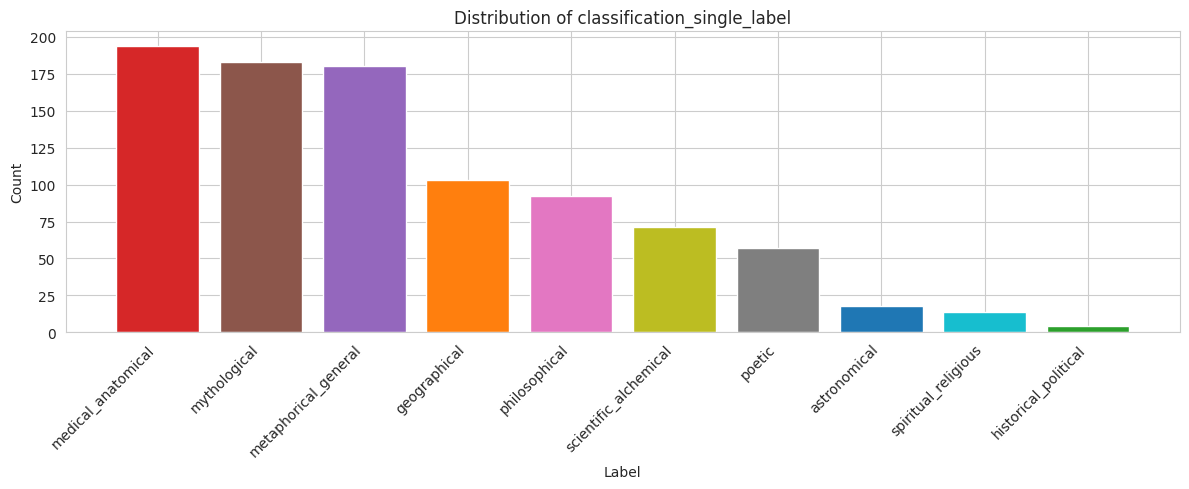

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm

# Count occurrences of each label
label_counts = labyrinthus_df["classification_single_label"].value_counts()
unique_lbls = sorted(label_counts.index)
N = len(unique_lbls)

# Define discrete color palette as before
cmap_name = "tab20" if N > 10 else "tab10"
cmap = cm.get_cmap(cmap_name, N)
palette = {lbl: cmap(i) for i, lbl in enumerate(unique_lbls)}

# Create the bar plot
fig, ax = plt.subplots(figsize=(12, 5))
bars = ax.bar(
    [str(lbl) for lbl in label_counts.index],        # x-ticks
    label_counts.values,                             # Heights
    color=[palette[lbl] for lbl in label_counts.index]
)

ax.set_title("Distribution of classification_single_label")
ax.set_xlabel("Label")
ax.set_ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [14]:
fig.savefig("../figures/labyrinthus_classification_single_label_barplot.png", dpi=300)

In [11]:
labyrinthus_df.to_parquet("../data/labyrinthus_df_classified.parquet")

In [201]:
labyrinthus_df["classification"] = labyrinthus_df["classification"].apply(normalize_label)

In [202]:
labyrinthus_df["classification"].value_counts()

classification
mythological-architectural     198
medical-anatomical             154
metaphorical-error             143
metaphorical-poetic            102
scientific-anatomical           77
scientific-astronomical         36
metaphorical-spiritual          21
scientific-natural              18
architectural-architectural     17
medical-error                   14
scientific-architectural        13
poetic-architectural            13
scientific-alchemical           11
religious-spiritual              9
metaphorical-architectural       8
architectural                    7
architectural-natural            7
metaphorical-alchemical          6
alchemical-anatomical            6
architectural-anatomical         5
scientific-error                 5
medical-alchemical               4
medical-metaphorical             3
geographical-architectural       3
mythological-poetic              3
scientific-metaphorical          3
metaphorical-philosophical       2
poetic-historical                2
alche

In [ ]:
od.to_parquet("../data/labyrinthus_df_classified.parquet")

In [3]:
# Re-reading classification

In [12]:
## re-read the data

In [2]:
labyrinthus_df = pd.read_parquet("../data/labyrinthus_df_classified.parquet")

In [13]:
labyrinthus_df = labyrinthus_df[['author', 'title', 'grela_id', 'sentence_id', 'sentence_text',
       'context_3sents', 'tokens', 'concordance_tokens', 'classification', 'not_before',
       'not_after', 'date_random', 'lagt_genre', 'lagt_provenience',
       'noscemus_genre', 'noscemus_discipline', 'target_token_id',
       'target_char_start', 'target_char_end']]

In [14]:
labyrinthus_df.to_csv("../data/labyrinthus_df_classified.csv")

In [15]:
from sklearn.model_selection import train_test_split

# First, filter to only include classifications with more than 10 cases
class_counts = labyrinthus_df['classification'].value_counts()
classes_with_min_cases = class_counts[class_counts > 10].index

print(f"Classifications with >10 cases: {len(classes_with_min_cases)}")
print(f"Total cases in these classifications: {class_counts[classes_with_min_cases].sum()}")

# Filter the dataframe to only include these classifications
filtered_df = labyrinthus_df[labyrinthus_df['classification'].isin(classes_with_min_cases)]



Classifications with >10 cases: 13
Total cases in these classifications: 817


In [16]:
# Create stratified sample of 100 rows from the filtered data
_, balanced_sample = train_test_split(
    filtered_df,
    test_size=100,
    random_state=42,
    stratify=filtered_df['classification']
)


In [17]:
balanced_sample.head(5)

,author,title,grela_id,sentence_id,sentence_text,context_3sents,tokens,concordance_tokens,classification,not_before,not_after,date_random,lagt_genre,lagt_provenience,noscemus_genre,noscemus_discipline,target_token_id,target_char_start,target_char_end
815,"Castelli, Bartolomeo",Lexicon medicum Graecolatinum Bartholomaei Cas...,noscemus_888129,noscemus_888129_35,"& ceco ductore, in uastissimum scientiarum cam...",Cum igitur experimento comprobauerim eos qui r...,"[{'char_end': 1, 'char_start': 0, 'lemma': '&'...","[{'char_end': 6, 'char_start': 2, 'lemma': 'ce...",metaphorical-error,1598.0,1598.0,1598.0,None,None,Dictionary/Lexicon,Medicine,139551870,68,79
221,Ennodius Ticinensis,Libellus apologeticus pro synodo,cc_7757,cc_7757_297,">> Post haec nos falsitatis arguitis, cur a pr...","Nouam deinde culpam, et quam inuestigatio nost...","[{'char_end': 1, 'char_start': 0, 'lemma': '>'...","[{'char_end': 100, 'char_start': 93, 'lemma': ...",metaphorical-error,473.0,521.0,521.0,None,None,None,None,296422374,135,145
62,Desiderius Erasmus,Adagia1508\n,cc_12132,cc_12132_29142,"Labyrinthus Laburinthon, id est labyrinthum, o...","Ii, X, 51. | Ii, X, 51. | Ii, X, 51. | Ii, X, ...","[{'char_end': 11, 'char_start': 0, 'lemma': 'l...","[{'char_end': 39, 'char_start': 33, 'lemma': '...",mythological-architectural,1466.0,1536.0,1493.0,None,None,None,None,255900145,0,11
3,Domnizo Canusinus,Vita et carmina Mathildis,cc_10261,cc_10261_892,"Ista fuit, quae par habuit regemque Deumque, H...","Ista fuit, quae diripuit Paulumque Petrumque; ...","[{'char_end': 4, 'char_start': 0, 'lemma': 'is...","[{'char_end': 43, 'char_start': 40, 'lemma': '...",metaphorical-error,1130.0,1130.0,1130.0,None,None,None,None,230188102,86,97
542,"Gemma-Frisius, Cornelis","De naturae divinis characterismis, seu raris e...",noscemus_718636,noscemus_718636_1499,"saepe & textum neruosum, implicitum instar lab...",I. 38 interiore sinu (si adaperias) solam inue...,"[{'char_end': 5, 'char_start': 0, 'lemma': 'sa...","[{'char_end': 69, 'char_start': 60, 'lemma': '...",medical-anatomical,1575.0,1575.0,1575.0,None,None,"Other (see description), Encyclopedic work",Medicine,134365920,43,53


In [18]:
balanced_sample.to_csv("../data/labyrinthus_df_balanced_sample.csv")

In [ ]:
def _layer_feats(row, layer, token_type="regular"):
    """
    Extract layer features for different token types.
    
    Parameters:
    -----------
    row : pd.Series
        DataFrame row containing the token data
    layer : int
        Layer number to extract features from
    token_type : str
        Either "regular" or "concordance" to specify which tokens to use
    
    Returns:
    --------
    pd.Series with embedding and attention features
    """
    if token_type == "regular":
        aug_tokens_col = "xlmr_aug_tokens"
        sent_str_col = "xlmr_sentence"
        embed_col = f"embed_l{layer}"
        att_col = f"att_l{layer}"
    elif token_type == "concordance":
        aug_tokens_col = "xlmr_conc_aug_tokens"
        sent_str_col = "xlmr_conc_text"
        embed_col = f"embed_conc_l{layer}"
        att_col = f"att_conc_l{layer}"
    else:
        raise ValueError("token_type must be 'regular' or 'concordance'")
    
    emb = hidden_anchor_embedding(
        aug_tokens   = row[aug_tokens_col],
        sent_str     = row[sent_str_col],
        tokenizer    = tokenizer,
        model        = model,
        device       = DEVICE,
        target_lemma = "labyrinthus",
        layer_idx    = layer,
        piece_pooling= "mean",
    )
    att = attention_weights_by_lemma(
        aug_tokens   = row[aug_tokens_col],
        sent_str     = row[sent_str_col],
        tokenizer    = tokenizer,
        model        = model,
        device       = DEVICE,
        target_lemma = "labyrinthus",
        att_layer    = layer,
    )
    return pd.Series({embed_col: emb, att_col: att})

# Generate features for regular tokens
for L in range(5, 12):           # layers 5-11
    labyrinthus_df[[f"embed_l{L}", f"att_l{L}"]] = (
        labyrinthus_df.apply(_layer_feats, layer=L, token_type="regular", axis=1)
    )

# Generate features for concordance tokens
for L in range(5, 12):           # layers 5-11
    labyrinthus_df[[f"embed_conc_l{L}", f"att_conc_l{L}"]] = (
        labyrinthus_df.apply(_layer_feats, layer=L, token_type="concordance", axis=1)
    )
